#  Predicting number of taxi orders

In [22]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from IPython.display import display
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("flare")

## Data preprocessing

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


The indexes are in chronological order, therefore sorting is not required.

In [4]:
print(f'Are indexes in chronological order? {df.index.is_monotonic}')

Are indexes in chronological order? True


In [5]:
print('Unique variable values.\n')
print('Years:', *df.index.year.unique())
print('Months:', *df.index.month.unique())
print('Days of month:', *df.index.day.unique())
print('Days of week:', *df.index.dayofweek.unique())
print('Hours:', *df.index.hour.unique())

Unique variable values.

Years: 2018
Months: 3 4 5 6 7 8
Days of month: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
Days of week: 3 4 5 6 0 1 2
Hours: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23


In [6]:
display(df.describe())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


There is no missing values in data frame.

In [8]:
print(f'Number of missing values in dataframe: {df.isna().sum().sum()}')

Number of missing values in dataframe: 0


Let't resample data by one hour.

In [10]:
df_hours = df.resample('1H').sum().copy()

Now we will visualize time series. In addition, we will show rolling mean (one week size) on graph.

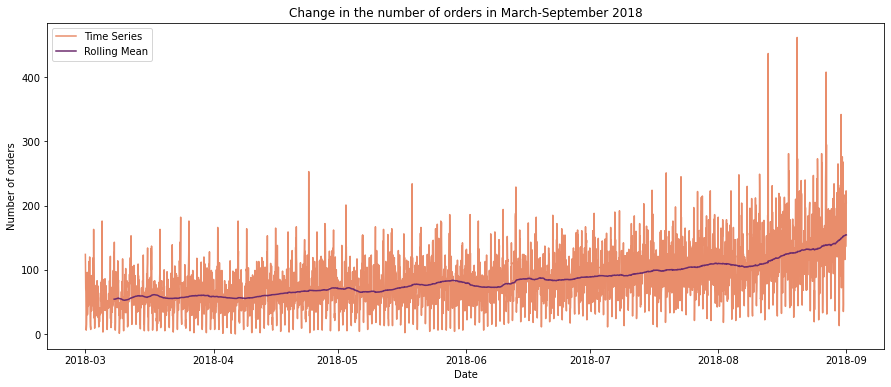

In [66]:
plt.figure(figsize=(15,6))
sns.lineplot(x=df_hours.index, y=df_hours['num_orders'], color = color[0], label='Time Series')
sns.lineplot(x=df_hours.index, y=df_hours['num_orders'].rolling(168).mean(), color = color[5], label='Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Change in the number of orders in March-September 2018')
plt.legend()
plt.show()

## Data analysis

Let's decimpose data by one hour.

In [13]:
df_decomposed = seasonal_decompose(df_hours)

We observe a positive trend - the number of orders is growing by months. The seasonality graph shows that it exists, but its nature is difficult to determine at the moment. Let's consider seasonality in more details later. Residual decomposition is a stationary stochastic process since mean and variance do not change over time.

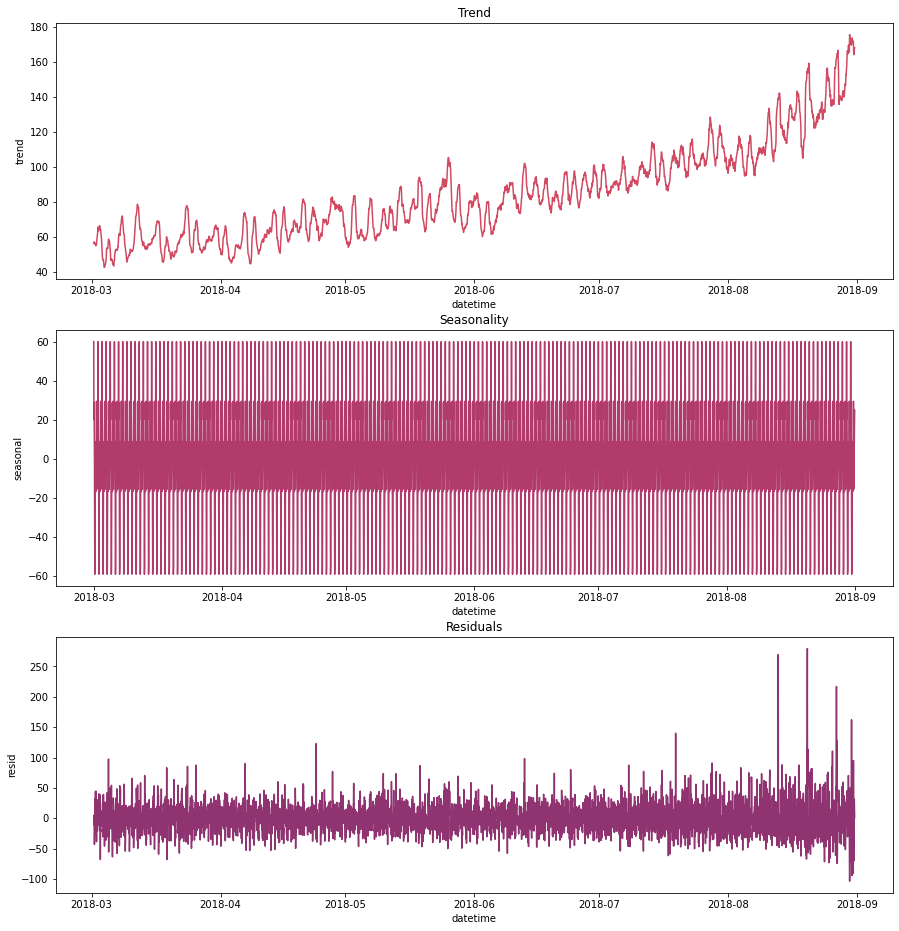

In [14]:
plt.figure(figsize=(15,16))

plt.subplot(311)
sns.lineplot(df_decomposed.trend, ax=plt.gca(), color=color[2])
plt.title('Trend')

plt.subplot(312)
sns.lineplot(df_decomposed.seasonal, ax=plt.gca(), color=color[3])
plt.title('Seasonality')

plt.subplot(313)
sns.lineplot(df_decomposed.resid, ax=plt.gca(), color=color[4])
plt.title('Residuals')
plt.show()

Let's study seasonality. We see seasonality by day, and on a larger scale by week (see graphs below). We must take this into account when generating features. Therefore, let's use rolling mean by day - 24, and time lag by the week - 168 as features.

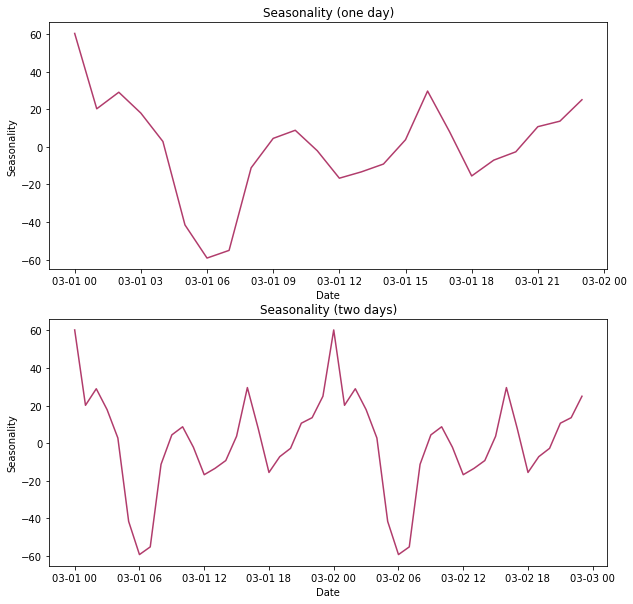

In [19]:
plt.figure(figsize=(10,10))

plt.subplot(211)
sns.lineplot(df_decomposed.seasonal[:24], ax=plt.gca(), color=color[3])
plt.title('Seasonality (one day)')
plt.xlabel('Date')
plt.ylabel('Seasonality')

plt.subplot(212)
sns.lineplot(df_decomposed.seasonal[:48], ax=plt.gca(), color=color[3])
plt.title('Seasonality (two days)')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.show()

Let's decompose data by weeks to see seasonality on a different scale. Firstly, we need to resample data by day.

In [16]:
df_weeks = df.resample('1D').sum().copy()
df_decomposed2 = seasonal_decompose(df_weeks)

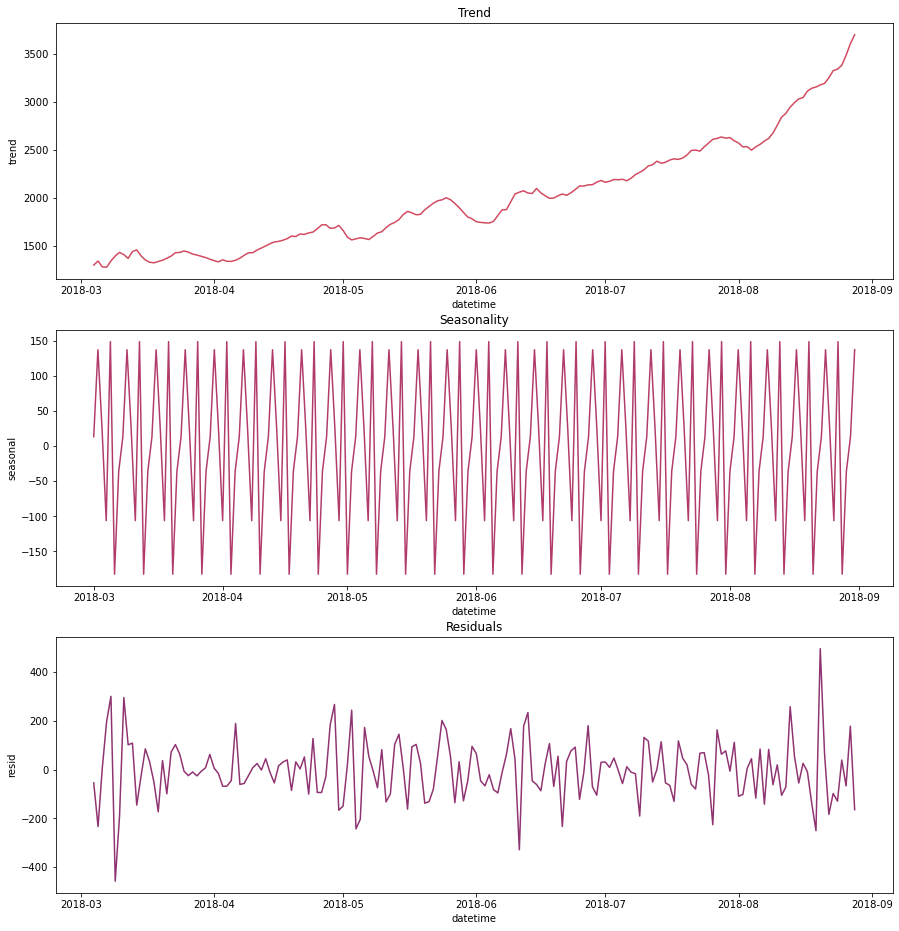

In [17]:
plt.figure(figsize=(15,16))

plt.subplot(311)
sns.lineplot(df_decomposed2.trend, ax=plt.gca(), color=color[2])
plt.title('Trend')

plt.subplot(312)
sns.lineplot(df_decomposed2.seasonal, ax=plt.gca(), color=color[3])
plt.title('Seasonality')

plt.subplot(313)
sns.lineplot(df_decomposed2.resid, ax=plt.gca(), color=color[4])
plt.title('Residuals')
plt.show()

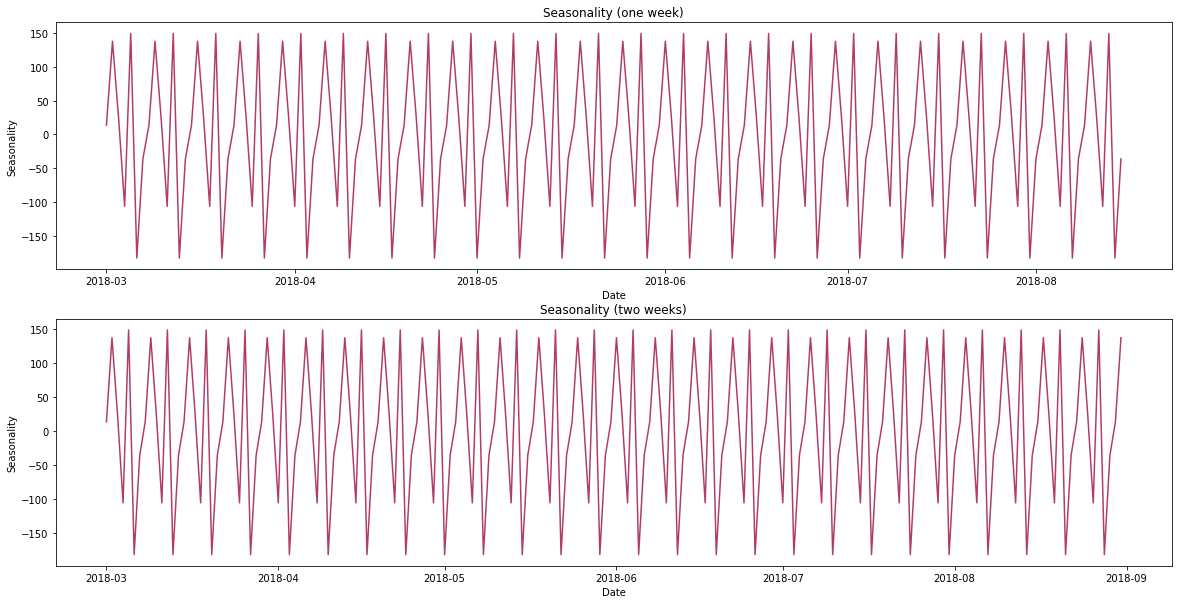

In [18]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.lineplot(df_decomposed2.seasonal[:168], ax=plt.gca(), color=color[3])
plt.title('Seasonality (one week)')
plt.xlabel('Date')
plt.ylabel('Seasonality')

plt.subplot(212)
sns.lineplot(df_decomposed2.seasonal[:336], ax=plt.gca(), color=color[3])
plt.title('Seasonality (two weeks)')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.show()

We use the `make_features` function to generate calendar features, time lag features, and rolling mean. We chose the hour and day of week as features since we observe seasonality by week and day.

In [20]:
def make_features(data, max_lag=1, rolling_mean_size=1):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
make_features(df_hours, max_lag=168, rolling_mean_size=24)
display(df_hours.head())

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will generate trigonometric features from `dayofweek` and `hour` variables. We will encode each of those periodic features using a sine and cosine transformation with the matching period. Each ordinal time feature is transformed into 2 features that together encode equivalent information in a non-monotonic way, and more importantly without any jump between the first and the last value of the periodic range. For more details refer to the [link](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

In [23]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [25]:
transformer = ColumnTransformer(
    transformers=[
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
        ("dayofweek_sin", sin_transformer(7), ["dayofweek"]),
        ("dayofweek_cos", cos_transformer(7), ["dayofweek"]),
    ],
    remainder='passthrough',
)

## Model fitting

We split data into test and train sample in the proportion of 90:10. Then, we remove missing values from the train sample.

In [28]:
train, test = train_test_split(df_hours, shuffle=False, test_size=0.1)
print(train.shape, test.shape)

(3974, 172) (442, 172)


In [29]:
train = train.dropna()
print(f'Number of missing values in train sample: {train.isna().sum().sum()}')

Number of missing values in train sample: 0


Let't get features and target and assign them to the corresponding variables.

In [30]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3806, 171) (3806,)
(442, 171) (442,)


### Dummy Regressor

Let's fit dummy model to compare with it results of fitting linear regression, decision tree regressor and random forest regressor.

In [31]:
dummy_model = Pipeline([('transformer', transformer), ('dummy_model', DummyRegressor())])

In [32]:
start_time = time.time()
dummy_model.fit(features_train, target_train)
dummy_time = time.time() - start_time

In [33]:
start_time = time.time()
dummy_pred = dummy_model.predict(features_train)
dummy_pred_time = time.time() - start_time

In [49]:
print('Fitting results.\n')
print('Fitting time:', round(dummy_time, 5))
print('Prediction time:', round(dummy_pred_time, 5))
print('RMSE on cross-validation:', round(np.mean(-cross_val_score(dummy_model, features_train, target_train, 
                                                                  cv=TimeSeriesSplit(n_splits=5), 
                                                                  scoring='neg_root_mean_squared_error')), 2))

Fitting results.

Fitting time: 0.0229
Prediction time: 0.01935
RMSE on cross-validation: 40.5


More simple algorithm is prediction by the previous value. We see, that result is better than the previous one.

In [35]:
pred_median = np.ones(target_train.shape)*target_train.shift(-1).fillna(method='ffill')
print('RMSE of prediction by previous value:', mean_squared_error(target_train, pred_median, squared=False))

RMSE of prediction by previous value: 36.348151590070074


### Linear Regression

Next let's fit Linear Regression.

In [36]:
lin_model = Pipeline([('transformer', transformer), ('lin_model', LinearRegression())])

In [37]:
start_time = time.time()
lin_model.fit(features_train, target_train)
lin_time = time.time() - start_time

In [38]:
start_time = time.time()
lin_pred = lin_model.predict(features_train)
lin_pred_time = time.time() - start_time

In [48]:
print('Fitting results.\n')
print('Fitting time:', round(lin_time, 5))
print('Prediction time:', round(lin_pred_time, 5))
print('RMSE on cross-validation:', round(np.mean(-cross_val_score(lin_model, features_train, target_train, 
                                                                  cv=TimeSeriesSplit(n_splits=5), 
                                                                  scoring='neg_root_mean_squared_error')), 2))

Fitting results.

Fitting time: 0.08595
Prediction time: 0.02099
RMSE on cross-validation: 22.58


### Decision Tree Regressor

Now let's observe the results of decision tree regressor parameters search and model fitting.

In [43]:
tree = Pipeline([('transformer', transformer), ('tree_model', DecisionTreeRegressor(random_state=42))])

tree_params = {'tree_model__max_depth': range(2, 10),
               'tree_model__min_samples_leaf': range(2, 6),
               'tree_model__min_samples_split': range(1, 4)}

tree_model = GridSearchCV(tree, param_grid=tree_params, 
                          cv=TimeSeriesSplit(n_splits=5), 
                          scoring='neg_root_mean_squared_error')

In [44]:
start_time = time.time()
tree_model.fit(features_train, target_train)
tree_time = time.time() - start_time

In [47]:
print('Fitting results.\n')
print(f'Grid search time: {round(tree_time, 2)} сек')
print(f'Fitting time: {round(tree_model.cv_results_["mean_fit_time"][tree_model.best_index_], 5)} сек')
print(f'Prediction time: {round(tree_model.cv_results_["mean_score_time"][tree_model.best_index_], 5)} сек')
print('Best params:')
pprint.pprint(tree_model.best_params_)

Fitting results.

Grid Search time: 40.37 сек
Fitting time: 0.08471 сек
Prediction time: 0.00435 сек
Best params:
{'tree_model__max_depth': 4,
 'tree_model__min_samples_leaf': 4,
 'tree_model__min_samples_split': 2}


In [50]:
print('Results of cross-validation.\n')
print('RMSE on cross-validation:', round(np.mean(-cross_val_score(tree_model.best_estimator_, features_train, target_train, 
                                                                  cv=TimeSeriesSplit(n_splits=5), 
                                                                  scoring='neg_root_mean_squared_error')), 2))

Results of cross-validation.

RMSE on cross-validation: 26.47


### Random Forest Regressor

Finally, let's fit Random Forest Regressor.

In [53]:
forest = Pipeline([('transformer', transformer), ('forest_model', RandomForestRegressor(random_state=42, n_jobs=-1))])

forest_params = {'forest_model__max_depth': range(3, 15),
                 'forest_model__n_estimators': [70, 80, 85]}

forest_model = GridSearchCV(forest, param_grid=forest_params, 
                            cv=TimeSeriesSplit().split(features_train), 
                            scoring='neg_root_mean_squared_error')

In [54]:
start_time = time.time()
forest_model.fit(features_train, target_train)
forest_time = time.time() - start_time

In [55]:
print('Fitting results.\n')
print(f'Grid search time: {round(forest_time/60, 2)} мин')
print(f'Fitting time: {round(forest_model.cv_results_["mean_fit_time"][forest_model.best_index_], 5)} сек')
print(f'Prediction time: {round(forest_model.cv_results_["mean_score_time"][forest_model.best_index_], 5)} сек')
print('Best params:')
pprint.pprint(forest_model.best_params_)

Fitting results.

Grid search time: 5.3 мин
Fitting time: 2.65983 сек
Prediction time: 0.02061 сек
Best params:
{'forest_model__max_depth': 14, 'forest_model__n_estimators': 85}


In [56]:
print('Results of cross-validation.\n')
print('RMSE on cross-validation:', round(np.mean(-cross_val_score(forest_model.best_estimator_, features_train, target_train, 
                                                                  cv=TimeSeriesSplit(n_splits=5), 
                                                                  scoring='neg_root_mean_squared_error')), 2))

Results of cross-validation.

RMSE on cross-validation: 22.79


**Summary:** All three models (Linear Regression, Decision Tree Regressor, Random Forest Regressor) predict better than Dummy Regressor (predicting by average). They are also better than approach of predicting by previous value. After comparing three models, we came to the conclusion that Linear Regression has the best results – it has a lower RMSE on cross-validation. Random Forest Regressor shows similar result, but it takes longer to fit. Therefore, it is proposed to use a linear model for pridecting the number of taxu orders.

|Model|Fitting time|Prediction time|RMSE on cross-validation|
|:-----|:-------------|:-----------------|:----------------------|
|Linear Regression| 0.086 s|0.021 s|22.58|
|Random Forest Regressor|2.660 s|0.021 s|22.79|
|Decision Tree Regressor|0.085 s|0.004 s|26.47|
|Dummy Regressor|0.0229 s|0.019 s|40.5|

## Model Testing

Let's use Linear Regression to predict the number of taxi orders for the next hour.

In [57]:
print('RMSE on test sample:', mean_squared_error(target_test, lin_model.predict(features_test), squared=False))

RMSE on test sample: 34.44333955477143


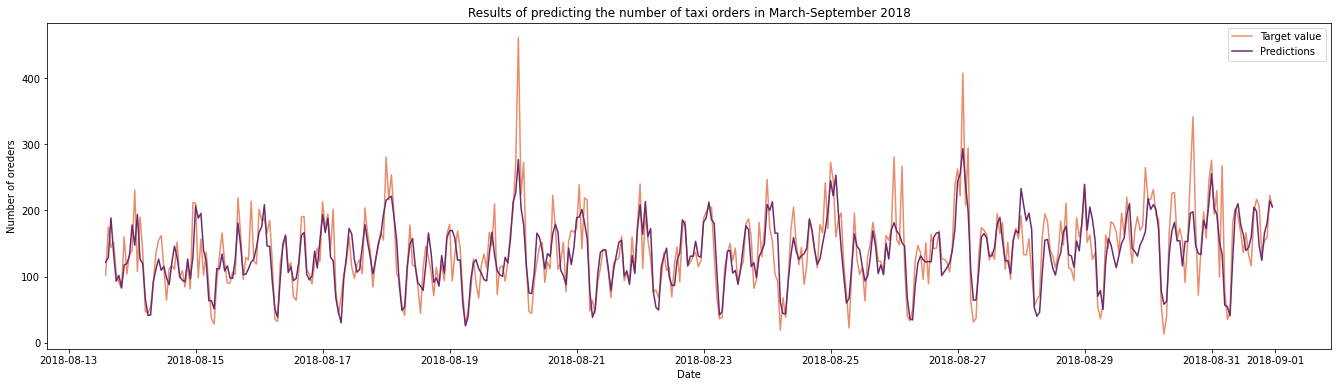

In [65]:
plt.figure(figsize=(23,6))
sns.lineplot(x=target_test.index, y=target_test, color = color[0], label='Target value')
sns.lineplot(x=target_test.index, y=lin_model.predict(features_test), color = color[5], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Number of oreders')
plt.title('Results of predicting the number of taxi orders in March-September 2018')
plt.legend()
plt.show()

## Conclusion

The goal of the project is to select ML model to predict the number of taxi orders for the next hour. RMSE was chosen as a quality metric, the error threshold is no more than 48 orders. At the first stage, we preprocessed data - resample it by 1 hour and took the average for each group. At the second stage, data on taxi orders in March-September 2018 were analyzed. A positive trend was revealed - orders were increasing every month. What is more, we observe day and week seasonality. Based on the results of the analysis, new variables were generated: calendar values (hour and day of week), rolling mean (size=24 hours) and time lag (size=168 hours or 1 week). Next, three models were trained and evaluated: linear regression, decision tree regressor, and random forest regressor. The results of the models were compared with each other, as well as with the baseline model - dummy regressor. In addition, we compared predictions of these models with the results of the model that makes predictions using previous value in time seris. According to the results of model fitting and RMSE on cross-validation, linear regression showed the best results. Therefore, we chose this model as the final one. RMSE on the test set is 34.44.